# IMDB Reviews Reactions


### 1. Importing the necessary libraries:


In [126]:
import tensorflow as tf 
import pandas as pd
import numpy as np
from sklearn import model_selection

### 2. Defining hyperparameter:

In [127]:
vocabulary_size = 10000
max_length = 64
filter = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

### 3. Importing trainining and testing data:

In [128]:
#Reading the training and testing dataset into a dataframe.
imdb_df_train=pd.read_csv('/content/train.csv', header=0) 
imdb_df_test=pd.read_csv('/content/test.csv', header=0)

#Extracting the training and testing inputs ("text") column from the dataset.
text_train = imdb_df_train.text
text_test = imdb_df_test.text

### 4. Data Preprocessing:

In [129]:
#Using the tokenizer API to convert 'texts' to numbers.
#Setting the number of words to convert (num_words), the word (token) to replace the unincluded words (oov_token) and the symbols to be ignored (filters).
tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=vocabulary_size,oov_token='<oov>', filters=filter) 
tokenizer.fit_on_texts(text_train) #Applying the tokenizer on the training set.

text_train_seq=tokenizer.texts_to_sequences(text_train) #Converting the texts into sequences of numbers.
text_test_seq=tokenizer.texts_to_sequences(text_test)

print('review sequences :' ,text_train_seq[:10]) #Previewing a review sequence>

#Padding the sequences to ensure that the data are of a uniform shape by either eliminating the sequences or padding it with zeros. 
x_train=tf.keras.preprocessing.sequence.pad_sequences(text_train_seq,maxlen=max_length,padding='post')
x_test=tf.keras.preprocessing.sequence.pad_sequences(text_test_seq,maxlen=max_length,padding='post')

review sequences : [[2, 139, 3, 679], [2, 40, 101, 60, 8, 15, 494, 5, 15, 3496, 553, 32, 60, 61, 128, 148, 76, 1480, 4, 22, 1255], [17, 3060, 7, 1149, 5, 286, 2, 3, 495, 438], [2, 24, 165, 8, 665, 27, 6, 4158, 2, 59, 47, 9, 13, 22, 72, 30, 6, 3497], [2, 24, 8, 1065], [73, 48, 8, 7, 56, 521, 319, 328, 158, 161, 9, 20], [73, 48, 329, 35, 7401, 35, 196, 7402, 888, 4, 73, 2475, 1384, 7, 159, 1885, 19, 2, 117, 3, 14, 15, 455], [2, 3, 29, 439, 27, 78, 29, 7, 1686, 35, 29, 760, 29, 7, 193, 267, 374], [2, 21, 48, 25, 5260, 16, 215, 2, 3, 9, 5260, 99, 5261, 135, 4, 132, 7, 1038, 4159], [2, 3, 666, 94]]


### 5. Encoding the target (y) values:

In [130]:
#Replacing the emojis within the dataframe in 'emojis' column with integer values using (replace()) function, as neural networks only deals with numbers.
imdb_df_train.replace({'😢':0,'😡': 1, '😍': 2, '😲': 3, '😨': 4, '😄': 5}, inplace=True)
imdb_df_test.replace({'😢':0,'😡': 1, '😍': 2, '😲': 3, '😨': 4, '😄': 5}, inplace=True)

#Extracting the training and testing targets ("emojis") column from the dataset.
y_train = imdb_df_train.emoji
y_test = imdb_df_test.emoji

#Using one_hot() function to encode the classes to (0,1) to prevent the model from assuming a natural ordering between categories that may result in poor performance. 
y_train_onehot, y_test_onehot = tf.one_hot(y_train, depth=6), tf.one_hot(y_test, depth=6)

### 6. Data pipeline:

In [131]:
#Building a function to build data pipeline with our dataset.
def dataset_creater(x,y):
    data=tf.data.Dataset.from_tensor_slices((x,y)) #Using tf.data API to perform data pipeline.
    data=data.shuffle(1028) #Shuffling the data with 1028 seed.
    data=data.batch(64) #Setting the batch size during training to 32. 
    data=data.prefetch(tf.data.experimental.AUTOTUNE) #Using data.prefetch() function to make the CPU perform multithreading.
    return data

#Using data pipeline function on our training dataset.
train_dataset=dataset_creater(x_train,y_train_onehot)
test_dataset=dataset_creater(x_test,y_test_onehot)

### 7. Building, Compiling and Training the classification model:

In [173]:
#Deleting tensorflow and importing it again to prevent the model from the saving the weights after training.
del tf 
import tensorflow as tf 

tf.random.set_seed(42) #Setting the graph-level random seed to get the same random numbers at every session (reproducible results).

#Building the model using tensorflow's Sequential API for easier implementation.
model=tf.keras.Sequential(
    [tf.keras.layers.Input([max_length]), #input shape is similar to the padded sequence max length.
     tf.keras.layers.Embedding(vocabulary_size+1,max_length, mask_zero=True), #Embedding layer with dimension of vacabulary size + 1 (to take paddings into consideration)
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)), #Bidirection LSTM layer with return_sequences set to True to add another LSTM layer.
     tf.keras.layers.Dropout(rate=0.5), #Dropout layer to reduce overfitting.
     tf.keras.layers.Dense(6, activation=tf.nn.softmax)] #Classification layer (dense).
    )

In [174]:
#Compiling the model by using Adam() as the optimizer and CategoricalCrossentropy() as this is a multi-class problem.
model.compile(optimizer=tf.optimizers.Adam(),loss=tf.losses.CategoricalCrossentropy(),metrics=['acc'])

#Using callbacks (ModelCheckpoint) to save the best model from training.
save_model=tf.keras.callbacks.ModelCheckpoint('Ahmed_Najah.h5',save_best_only=True)

#Training the model.
history = model.fit(train_dataset,epochs=10,validation_data=test_dataset,callbacks=[save_model])

Epoch 1/10
250/250 [==============================] - 75s 270ms/step - loss: 1.5255 - acc: 0.3790 - val_loss: 0.6924 - val_acc: 0.7525
Epoch 2/10
250/250 [==============================] - 65s 260ms/step - loss: 0.5807 - acc: 0.8016 - val_loss: 0.3709 - val_acc: 0.8730
Epoch 3/10
250/250 [==============================] - 65s 259ms/step - loss: 0.2199 - acc: 0.9292 - val_loss: 0.2895 - val_acc: 0.8970
Epoch 4/10
250/250 [==============================] - 65s 259ms/step - loss: 0.1239 - acc: 0.9582 - val_loss: 0.3086 - val_acc: 0.9050
Epoch 5/10
250/250 [==============================] - 65s 258ms/step - loss: 0.0925 - acc: 0.9710 - val_loss: 0.3197 - val_acc: 0.9025
Epoch 6/10
250/250 [==============================] - 64s 256ms/step - loss: 0.0679 - acc: 0.9788 - val_loss: 0.3559 - val_acc: 0.8975
Epoch 7/10
250/250 [==============================] - 65s 259ms/step - loss: 0.0561 - acc: 0.9818 - val_loss: 0.3258 - val_acc: 0.9060
Epoch 8/10
250/250 [==============================] - 6

### 8. Plotting the training results:

AttributeError: ignored

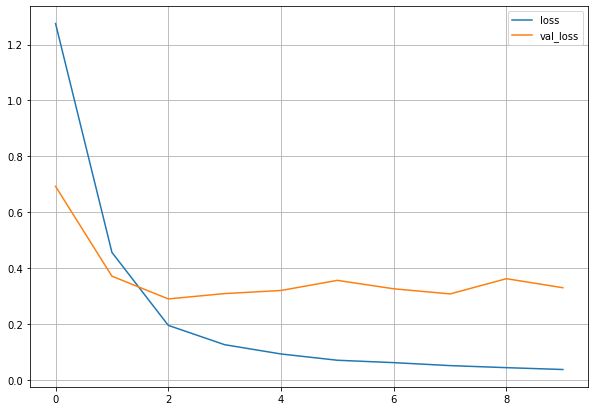

In [175]:
#Plotting the results to look for overfitting within the results.
#Converting the results into a data frame using Pandas tool.
import matplotlib.pyplot as plt
df = pd.DataFrame(history.history)
plt = df[['loss','val_loss']].plot(figsize=(10, 7))

#Plotting the data frame using matplotlib library.
plt.grid(True)
plt.gca().set_ylim(0,1) #Setting the x-axis.
plt.gca().set_xlim(0,9) #Setting the y-axis.
                              
plt.show()

### 9. Evaluating the model:

In [176]:
#Building a function to perform prediction on unseen data (text).
def predict(text):
  
  tokenized_texts = tokenizer.texts_to_sequences([text])
  input = tf.keras.preprocessing.sequence.pad_sequences(tokenized_texts, maxlen=64, padding='post')

  output = model.predict(input) #Using predict function on the input text.

  emojis = ['😢','😡', '😍', '😲', '😨','😄'] #The emojis to be used to describe the the input text (review).
  
  print("The Sentence: ", text)
  print('The model reaction: ', emojis[np.argmax(output)])

In [180]:
#Using CoLab forms to insert the text (review) that would be used to evaluate the model.
#@title String fields

text = 'it was sad' #@param {type:"string"}

predict(text)

The Sentence:  it was sad
The model reaction:  😢
